# Feature Selection Lab

In this lab we will explore feature selection on the Titanic Dataset. First of all let's load a few things:

- Standard packages
- The training set from lab 2.3
- The union we have saved in lab 2.3


You can load the titanic data as follows:

    psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
    password: gastudents

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


## 1. Import the data and EDA

We'll be working with the titanic datasets - go ahead and import it from the "assets" folder. While you're at it, take some time to do EDA and see what the data looks like! 

In [3]:
df = pd.read_csv('../assets/datasets/train.csv')

In [5]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
for item in df:
    print item
    print df[item].nunique()

PassengerId
891
Survived
2
Pclass
3
Name
891
Sex
2
Age
88
SibSp
7
Parch
7
Ticket
681
Fare
248
Cabin
147
Embarked
3


Lets be real, a Persons name, their passenger ID, Ticket number and Cabin probably wont have any affect.  Although, if we can find out where the cabin was and use that to create a geographic category, that may be of more use.

I also found this out last time I worked with this dataset.

In [9]:
#dropped passengerid, name, ticket, and cabin
df.drop('PassengerId', inplace=True, axis=1)
df.drop('Name', inplace=True, axis=1)
df.drop('Ticket', inplace=True, axis=1)
df.drop('Cabin', inplace=True, axis=1)

In [10]:
#imputed the median for Age to fill the nulls
df.Age.fillna(df.Age.median(), inplace=True)

# Mean and median age values are very close (28 and 29) and it is rare that we ever get to use median.

In [11]:
#made dummy variables for embarked, dropping the original Embarked column and 'S' (the most common embarcation point)
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop('S', inplace=True, axis=1)
df.drop('Embarked', inplace=True, axis=1)
# I could just use drop_first = true, but there is more than one way to do anything.

In [12]:
#instead of sex, create a column called 'male' with a binary value
df['Male'] = df.Sex.apply(lambda x: 'female' not in str(x))

#drop the original Sex column
df.drop('Sex', inplace=True, axis=1)

# We haven't use a true boolean feature yet.  Lets see what happens!

In [13]:
df.head()
# Data After cleaning and parsing

,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,Male
0,0,3,22.0,1,0,7.2500,0.0,0.0,True
1,1,1,38.0,1,0,71.2833,1.0,0.0,False
2,1,3,26.0,0,0,7.9250,0.0,0.0,False
3,1,1,35.0,1,0,53.1000,0.0,0.0,False
4,0,3,35.0,0,0,8.0500,0.0,0.0,True


## 2. Feature selection

Let's use the `SelectKBest` method in scikit learn to see which are the top 5 features.

- What are the top 5 features for `Xt`?

=> store them in a variable called `kbest_columns`

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# this list of column names will come in handly later.
cols = list(df.columns)
cols.remove('Survived')

X = df[cols]
y = df.Survived.values

In [36]:
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2, SelectPercentile, GenericUnivariateSelect, f_classif
knn = KNeighborsClassifier()
#build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

#train the selector on our data
skb_f.fit(X, y)
skb_chi2.fit(X, y)

#examine results
pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)

,feature,f_classif,chi2 score
7,Male,372.406,92.7024
0,Pclass,115.031,30.8737
4,Fare,63.0308,4518.32
5,C,25.896,20.4644
3,Parch,5.96346,10.0975
1,Age,3.76153,21.6492
2,SibSp,1.11057,2.58187
6,Q,0.0118463,0.0108468


According to one documentation, F test is suppose to be on a scale of 0-1 soooo....

- Its is explained variance divided by unexplained variance.

>High numbers will results if our explained variance, what we know is much greater than unexplained, what we dont know.

- Chi2 goodness of fit is the sum of the difference squared between observed and expected divided by expected

In [37]:
# these were the 5 Best columns that worked together.
kbest_columns = ['Male','Pclass','Fare','C','Parch']
# Manually interpreted this.  

## 3. Recursive Feature Elimination

`Scikit Learn` also offers recursive feature elimination as a class named `RFECV`. Use it in combination with a logistic regression model to see what features would be kept with this method.

=> store them in a variable called `rfecv_columns`

In [39]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
selector = RFECV(lr, step=.5, cv=5, verbose =4)
selector = selector.fit(X, y)
print selector.support_
print selector.ranking_


# step = elimiantes the bottom 50% of features
# verbose =  how many times it will conduct the Feature Elimination

Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
Fitting estimator with 8 features.
Fitting estimator with 4 features.
[ True False False False False False False  True]
[1 3 3 3 3 2 2 1]


In [40]:
# the column names correspond to the one below.  I manually created this
rfecv_columns = ['Pclass','C','Q','Male']

## 4. Logistic regression coefficients

Let's see if the Logistic Regression coefficients correspond.

- Create a logistic regression model
- Perform grid search over penalty type and C strength in order to find the best parameters
- Sort the logistic regression coefficients by absolute value. Do the top 5 correspond to those above?
> Answer: Not completely. That could be due to scaling
> Some features are going to perform better based on the model type and If we had not regularized some could be percieved as much more significant than they are.

=> choose which ones you would keep and store them in a variable called `lr_columns`

In [24]:
# What Does GridSearch think is best?
from sklearn.grid_search import GridSearchCV
model = GridSearchCV(LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                                            'penalty': ['l1', 'l2']})
model.fit(X, y)
print model.best_estimator_
print model.best_params_
print model.best_score_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l2', 'C': 1.0}
0.794612794613


In [25]:
# What are the Best Coefficients according to a model using Gridsearches best parameters?

coeffs = pd.DataFrame(model.best_estimator_.coef_, columns = X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['Surv coeff']
coeffs_t.abs().sort_values('Surv coeff', ascending=False)

,Surv coeff
Male,2.487752
Pclass,0.842322
C,0.431297
Q,0.289550
SibSp,0.287787
Parch,0.074106
Age,0.028374
Fare,0.004101


In [26]:
# keep the ones with coeff above 0.3
lr_columns = coeffs.columns[(coeffs.abs() > 0.3).values[0]]

## 5. Compare features sets

Use the `best estimator` from question 4 on the 3 different feature sets:

- `kbest_columns`
- `rfecv_columns`
- `lr_columns`
- `all_columns`

Questions:

- Which scores the highest? (use cross_val_score)
- Is the difference significant?
> Answer: Not really
- discuss in pairs

In [41]:
from sklearn.cross_validation import cross_val_score

# defining a function to test our best features head-to-head
def score(X):
    scores = cross_val_score(model.best_estimator_, X, y)
    return scores.mean(), scores.std()

# list of all our lists of best features being executes in the score function
all_scores = [
    score(X[kbest_columns]),
    score(X[rfecv_columns]),
    score(X[lr_columns]),
    score(X)]

#putting results into a dataframe
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr', 'all'])

,mean score,std score
kbest,0.774411,0.012598
rfecv,0.771044,0.008247
lr,0.771044,0.008247
all,0.794613,0.004762


Our Selected features tend to perform worse as opposed to using all the features which has a 2 point better r2 and the smallest standard deviation.

## Bonus 1

Use a bar chart to display the logistic regression coefficients. Start from the most negative on the left.

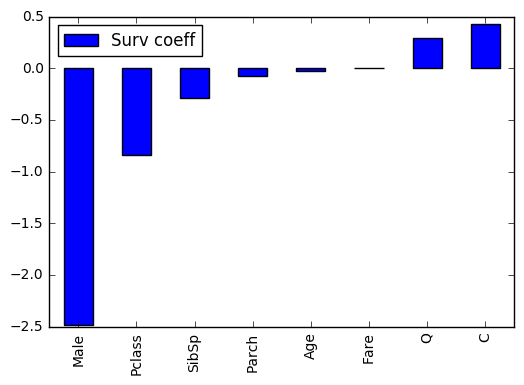

In [28]:
coeffs_t.sort_values('Surv coeff').plot(kind='bar')
